# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0.1,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': 3, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number

        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output


In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *


In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_21_drop0.25e500b256_custom/lnets_10000_30-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xdist_uniform_noise_normal_0.1
lnets_10000_30-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:   14.9s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
6252,1373158606,0.924,0.492,-0.142,-0.402,-0.741,0.255,0.941,0.421,-1.533,6.634,-11.500,5.498,0.911,0.605,-0.683,0.915,-2.125,0.759,-0.009,-0.227,0.414,0.340,0.169,0.103,0.419,-0.297,0.334,0.062,0.544,-0.088,-0.019,0.451,0.090,0.523,-0.042,0.202,0.265,0.229,-0.054,0.043,0.008,-0.042,-0.404,-0.090,0.333,-0.291,-0.209,-0.233,0.000,0.000,-0.212,-0.233,0.234,0.234,-0.286,0.000,-0.234,0.296,-0.243,0.000,0.000,-0.255,0.244,-0.205,0.232,0.254,0.227,0.242,0.288,-0.046,-0.023,0.000,0.000,0.000,-0.233,0.000,0.000,0.000,-0.254,-0.359,-0.566,-0.690,0.341,0.400,-0.479,-0.408,-0.789,0.120,-0.376,-0.352,-0.364,-0.443,0.341,-0.452,0.687,0.215,0.348,0.244,0.337,-0.311,-0.044,-0.261,-0.383,-0.059,-0.969,0.144,-0.258,-0.315,0.202
4684,1373158606,-0.794,0.241,-0.127,-0.188,-0.535,-0.939,-0.768,1.420,-14.454,48.213,-63.525,27.058,-0.794,0.232,0.112,-0.997,0.376,-1.277,-0.009,-0.227,0.231,0.122,0.313,0.080,0.185,-0.297,0.089,0.253,0.358,-0.088,-0.019,0.234,0.078,0.342,0.008,1.474,0.405,0.393,0.033,0.035,-0.043,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.000,0.172,0.175,0.001,-0.081,0.178,0.000,0.175,0.190,0.173,0.000,0.000,0.175,-0.079,0.172,-0.023,-0.949,0.001,0.000,-0.040,0.176,0.200,0.000,0.000,0.000,0.175,0.000,0.000,0.000,-0.254,-0.359,-0.339,-0.360,0.278,0.187,-0.191,-0.408,-0.396,-0.074,-0.188,-0.352,-0.364,-0.199,0.121,-0.265,0.393,-2.337,0.330,0.208,0.049,-0.458,-0.229,-0.261,-0.383,-0.059,-0.479,0.144,-0.258,-0.315,-0.168
1731,1373158606,-0.739,0.951,0.737,0.786,0.773,0.083,-0.721,0.346,4.731,-9.701,12.714,-4.814,-0.744,0.972,0.672,0.758,0.980,-0.046,-0.009,-0.227,-0.173,0.082,0.724,0.671,0.528,-0.297,0.067,0.916,0.416,-0.088,-0.019,0.349,0.689,-0.003,0.528,0.849,0.892,0.883,0.649,0.039,0.007,-0.042,-0.404,-0.090,0.046,-0.291,-0.209,-0.233,0.000,0.000,0.437,-0.092,-0.412,-0.438,-0.438,0.000,-0.078,-0.404,0.001,0.000,0.000,0.001,-0.463,0.398,-0.438,-0.280,-0.000,-0.140,-0.525,-0.054,-0.024,0.000,0.000,0.000,-0.060,0.000,0.000,0.000,-0.254,-0.359,-0.466,-0.215,0.917,1.043,0.791,-0.408,-0.251,0.617,0.148,-0.352,-0.364,0.190,1.010,-0.240,1.515,0.684,0.819,0.700,1.093,-0.306,-0.042,-0.261,-0.383,-0.059,-0.331,0.144,-0.258,-0.315,-0.437
4742,1373158606,0.173,-0.607,-0.085,0.746,-0.828,-0.939,0.161,-0.337,-2.491,8.142,-10.118,3.139,0.181,-0.787,0.885,-1.338,1.146,-1.629,-0.009,-0.227,0.511,0.469,0.050,-0.029,0.515,-0.297,0.433,0.595,0.678,-0.088,-0.019,0.540,-0.019,0.653,0.006,0.278,0.134,0.182,0.030,0.396,0.433,-0.042,-0.404,-0.090,0.397,-0.291,-0.209,-0.233,0.000,0.000,-0.264,-0.331,0.090,0.099,-0.363,0.000,-0.339,-0.404,-0.007,0.000,0.000,-0.279,0.089,-0.006,-0.025,-0.002,0.094,0.015,-0.044,-0.335,-0.366,0.000,0.000,0.000,-0.337,0.000,0.000,0.000,-0.254,-0.359,-0.691,-0.997,0.091,0.166,-0.746,-0.408,-1.085,-0.558,-0.418,-0.352,-0.364,-0.580,0.091,-0.495,0.391,-0.077,0.106,-0.017,0.043,-1.272,-1.217,-0.261,-0.383,-0.059,-1.255,0.144,-0.258,-0.315,0.121
4521,1373158606,0.131,0.208,0.871,0.323,0.573,0.164,0.124,0.308,0.697,-0.264,2.311,-0.934,0.132,0.241,0.293,2.685,-2.779,1.703,-0.009,-0.227,0.128,0.083,0.634,0.562,0.108,-0.297,0.067,0.951,0.400,-0.088,-0.019,0.126,0.521,0.243,0.398,0.706,0.723,0.705,0.612,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,0.001,-0.005,-0.000,0.004,-0.003,-0.003,0.004,-0.025,0.136,-0.544,0.793,-0.364,0.001,-0.006,0.003,0.001,-0.003,-0.001,-0.009,-0.227,0.287,0.192,0.282,0.221,0.275,-0.297,0.162,0.454,0.475,-0.088,-0.019,0.322,0.222,0.404,0.079,0.415,0.370,0.393,0.149,0.112,0.058,-0.042,-0.404,-0.090,0.123,-0.291,-0.209,-0.233,0.000,0.000,-0.015,-0.027,-0.009,-0.015,-0.051,0.000,-0.026,-0.082,-0.046,0.000,0.000,-0.045,-0.023,-0.004,0.013,-0.066,0.018,-0.031,-0.016,-0.016,0.004,0.000,0.000,0.000,-0.018,0.000,0.000,0.000,-0.254,-0.359,-0.372,-0.424,0.354,0.419,-0.210,-0.408,-0.465,0.040,-0.106,-0.352,-0.364,-0.189,0.364,-0.265,0.627,0.118,0.358,0.176,0.332,-0.521,-0.258,-0.261,-0.383,-0.059,-0.544,0.144,-0.258,-0.315,0.004
std,0.000,0.574,0.577,0.577,0.577,0.575,0.580,0.542,0.650,3.538,10.664,13.939,5.786,0.574,0.621,1.539,3.677,4.051,1.706,0.000,0.000,0.142,0.143,0.158,0.156,0.171,0.000,0.142,0.277,0.201,0.000,0.000,0.168,0.163,0.145,0.148,0.243,0.162,0.187,0.202,0.140,0.182,0.000,0.000,0.000,0.139,0.000,0.000,0.000,0.000,0.000,0.147,0.158,0.170,0.179,0.189,0.000,0.158,0.293,0.218,0.000,0.000,0.185,0.192,0.145,0.155,0.249,0.137,0.214,0.212,0.152,0.176,0.000,0.000,0.000,0.152,0.000,0.000,0.000,0.000,0.000,0.177,0.234,0.212,0.248,0.342,0.000,0.257,0.446,0.450,0.000,0.000,0.347,0.263,0.236,0.311,0.502,0.179,0.439,0.346,0.287,0.334,0.000,0.000,0.000,0.278,0.000,0.000,0.000,0.139
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.038,-2.548,-19.920,-73.162,-89.155,-43.752,-1.024,-1.581,-5.513,-14.253,-18.883,-6.767,-0.009,-0.227,-0.173,-0.289,-0.227,-0.278,-0.181,-0.297,-0.291,-0.132,0.099,-0.088,-0.019,-0.129,-0.290,-0.017,-0.301,-0.172,-0.094,-0.137,-0.640,-0.303,-0.633,-0.042,-0.404,-0.090,-0.291,-0.291,-0.209,-0.233,0.000,0.000,-0.469,-0.494,-0.560,-0.601,-0.958,0.000,-0.495,-1.158,-1.224,0.000,0.000,-1.010,-0.619,-0.962,-0.551,-1.123,-0.557,-1.056,-0.804,-0.496,-0.812,0.000,0.000,0.000,-0.496,0.000,0.000,0.000,-0.254,-0.359,-1.750,-1.862,-0.030,0.066,-1.360,-0.408,-2.213,-2.456,-0.918,-0.352,-0.364,-1.083,0.002,-0.982,0.260,-2.767,-1.802,-3.101,-0.695,-2.082,-3.002,-0.2

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.04991591],
       [0.55931928],
       [0.41215429],
       [0.47204459],
       [0.50702493],
       [0.36030918],
       [0.48300684],
       [0.91632547],
       [0.27265516],
       [0.88145597]])

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[1.0879322 ],
       [0.92128287],
       [0.94887895],
       [1.06356541],
       [1.04696906],
       [0.91303792],
       [0.84312583],
       [0.62768837],
       [1.02064446],
       [0.61265825]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        
        if isinstance(test_size, float):
            test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))
        
        test_seeds = random.sample(complete_seed_list, test_size)
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8910, 110)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(990, 110)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 110)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
5548,1373158606,-0.949,-0.480,0.832,0.336,0.839,-0.108,-0.991,-0.143,0.917,-3.996,9.113,-4.498,-0.955,-0.376,0.093,2.385,-1.553,0.893,-0.009,-0.227,0.129,0.008,0.565,0.482,0.058,-0.297,-0.027,0.077,0.260,-0.088,-0.019,0.118,0.479,0.247,0.390,0.626,0.658,0.643,0.492,-0.084,-0.212,-0.042,-0.404,-0.090,-0.068,-0.291,-0.209,-0.233,0.000,0.000,0.190,0.199,-0.272,-0.316,0.207,0.000,0.201,0.250,0.187,0.000,0.000,0.199,-0.359,0.185,-0.297,-0.372,-0.211,-0.307,-0.374,0.204,0.272,0.000,0.000,0.000,0.201,0.000,0.000,0.000,-0.254,-0.359,-0.367,-0.445,0.761,0.883,-0.250,-0.408,-0.499,-0.132,-0.175,-0.352,-0.364,-0.231,0.844,-0.255,1.297,0.665,0.721,0.657,0.906,-0.589,-0.389,-0.261,-0.383,-0.059,-0.604,0.144,-0.258,-0.315,-0.179
1854,1373158606,-0.964,0.445,0.671,-0.202,-0.104,0.703,-0.939,-0.239,5.055,-11.666,13.315,-5.025,-0.981,0.816,-1.615,5.775,-7.007,3.569,-0.009,-0.227,0.029,-0.094,0.468,0.400,-0.037,-0.297,-0.130,-0.000,0.175,-0.088,-0.019,0.024,0.414,0.153,0.323,0.530,0.595,0.571,0.395,-0.186,-0.273,-0.042,-0.404,-0.090,-0.171,-0.291,-0.209,-0.233,0.000,0.000,0.183,0.194,-0.219,-0.284,0.196,0.000,0.197,0.213,0.170,0.000,0.000,0.186,-0.297,0.174,-0.246,-0.309,-0.093,-0.161,-0.301,0.201,0.273,0.000,0.000,0.000,0.198,0.000,0.000,0.000,-0.254,-0.359,-0.332,-0.453,0.567,0.716,-0.228,-0.408,-0.523,-0.076,-0.106,-0.352,-0.364,-0.192,0.677,-0.193,1.095,0.504,0.562,0.454,0.720,-0.636,-0.444,-0.261,-0.383,-0.059,-0.646,0.144,-0.258,-0.315,-0.179
739,1373158606,-0.855,-0.439,-0.300,0.565,0.985,-0.519,-0.871,-0.373,0.449,-3.575,7.620,-3.879,-0.871,-0.202,-1.363,2.453,-0.341,-0.261,-0.009,-0.227,0.221,0.107,0.397,0.330,0.159,-0.297,0.072,0.183,0.344,-0.088,-0.019,0.213,0.346,0.332,0.008,0.486,0.463,0.465,0.427,0.015,-0.134,-0.042,-0.404,-0.090,0.031,-0.291,-0.209,-0.233,0.000,0.000,0.184,0.188,-0.207,-0.227,0.199,0.000,0.189,0.239,0.187,0.000,0.000,0.193,-0.251,0.183,-0.023,-0.253,-0.201,-0.243,-0.309,0.191,0.262,0.000,0.000,0.000,0.189,0.000,0.000,0.000,-0.254,-0.359,-0.350,-0.387,0.522,0.621,-0.212,-0.408,-0.430,-0.100,-0.192,-0.352,-0.364,-0.212,0.585,-0.269,0.393,0.395,0.506,0.412,0.773,-0.512,-0.347,-0.261,-0.383,-0.059,-0.527,0.144,-0.258,-0.315,-0.171
3588,1373158606,-0.904,0.600,-0.211,-0.681,-0.648,0.838,-0.758,-0.162,0.013,-0.029,0.029,-0.011,-0.902,0.571,-0.058,-1.495,0.895,-0.032,-0.009,-0.227,0.269,0.161,0.283,0.227,0.219,-0.297,0.127,0.269,0.393,-0.088,-0.019,0.268,0.228,0.379,0.008,0.340,0.361,0.348,0.033,0.074,-0.026,-0.042,-0.404,-0.090,0.087,-0.291,-0.209,-0.233,0.000,0.000,0.167,0.170,-0.001,-0.001,0.178,0.000,0.170,0.207,0.170,0.000,0.000,0.174,-0.001,0.167,-0.023,-0.002,-0.002,-0.002,-0.040,0.172,0.227,0.000,0.000,0.000,0.170,0.000,0.000,0.000,-0.254,-0.359,-0.356,-0.376,0.277,0.322,-0.208,-0.408,-0.412,-0.094,-0.207,-0.352,-0.364,-0.216,0.258,-0.284,0.393,0.152,0.305,0.189,0.049,-0.478,-0.276,-0.261,-0.383,-0.059,-0.498,0.144,-0.258,-0.315,-0.158
4649,1373158606,-0.424,-0.791,-0.275,-0.401,0.269,0.767,-0.398,-1.541,4.794,-14.016,16.066,-5.804,-0.432,-0.775,0.086,-1.848,2.083,0.032,-0.009,-0.227,0.359,0.253,0.377,0.353,0.314,-0.297,0.220,0.375,0.482,-0.088,-0.019,0.361,0.375,0.468,0.008,0.466,0.420,0.446,0.033,0.168,0.103,-0.042,-0.404,-0.090,0.180,-0.291,-0.209,

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
4197,1373158606,0.570,-0.035,-0.227,0.052,0.352,0.454,0.468,0.351,-0.147,0.330,-0.330,0.121,0.580,-0.103,0.472,-2.496,3.803,-1.111,-0.009,-0.227,0.256,0.078,0.281,0.218,0.211,-0.297,0.067,0.273,0.374,-0.088,-0.019,0.257,0.214,0.361,0.077,0.328,0.368,0.345,0.116,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.004,-0.080,0.136,0.136,-0.003,0.000,-0.069,0.124,-0.010,0.000,0.000,-0.004,0.139,-0.009,0.133,0.145,0.134,0.140,0.154,-0.047,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.261,-0.220,0.306,0.343,-0.098,-0.408,-0.258,0.047,-0.125,-0.352,-0.364,-0.117,0.278,-0.202,0.549,0.185,0.338,0.223,0.204,-0.310,-0.044,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,0.124
5318,1373158606,-0.166,-0.465,0.783,0.691,-0.194,-0.939,-0.151,-0.685,3.270,-6.074,5.289,-1.747,-0.137,-0.835,2.440,-2.618,2.869,-2.013,-0.009,-0.227,0.245,0.139,0.279,0.218,0.202,-0.297,0.106,0.283,0.369,-0.088,-0.019,0.248,0.214,0.354,0.078,0.328,0.364,0.344,0.125,0.054,-0.009,-0.042,-0.404,-0.090,0.066,-0.291,-0.209,-0.233,0.000,0.000,0.050,0.050,-0.039,-0.034,0.048,0.000,0.050,0.020,0.048,0.000,0.000,0.048,-0.034,0.049,-0.014,-0.044,-0.044,-0.044,-0.022,0.050,0.051,0.000,0.000,0.000,0.050,0.000,0.000,0.000,-0.254,-0.359,-0.264,-0.261,0.267,0.297,-0.104,-0.408,-0.287,0.011,-0.128,-0.352,-0.364,-0.121,0.231,-0.205,0.472,0.149,0.306,0.188,0.136,-0.333,-0.087,-0.261,-0.383,-0.059,-0.358,0.144,-0.258,-0.315,-0.051
3815,1373158606,0.551,-0.751,0.307,-0.409,0.521,-0.519,0.543,-0.535,-1.132,3.643,-4.751,1.981,0.575,-1.205,3.115,-7.447,8.133,-3.490,-0.009,-0.227,0.370,0.270,0.151,0.087,0.304,-0.297,0.248,0.448,0.508,-0.088,-0.019,0.393,0.081,0.490,-0.059,0.198,0.241,0.216,-0.035,0.202,0.190,-0.042,-0.404,-0.090,0.210,-0.291,-0.209,-0.233,0.000,0.000,-0.007,-0.187,0.156,0.160,-0.148,0.000,-0.171,-0.002,-0.003,0.000,0.000,-0.002,0.163,-0.002,0.171,0.153,0.152,0.152,0.200,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.254,-0.359,-0.380,-0.552,0.264,0.327,-0.252,-0.408,-0.591,-0.125,-0.256,-0.352,-0.364,-0.253,0.265,-0.333,0.651,0.129,0.274,0.162,0.272,-0.477,-0.247,-0.261,-0.383,-0.059,-0.498,0.144,-0.258,-0.315,0.154
9727,1373158606,0.688,0.086,0.700,0.490,-0.303,-0.629,0.627,0.767,-0.988,2.330,-1.827,0.166,0.694,-0.190,2.291,-3.274,3.736,-2.230,-0.009,-0.227,0.300,0.275,0.307,0.245,0.314,-0.297,0.067,0.300,0.342,-0.088,-0.019,0.307,0.240,0.331,0.104,0.355,0.394,0.371,0.144,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.236,-0.215,0.169,0.169,-0.246,0.000,-0.069,0.156,-0.001,0.000,0.000,-0.240,0.173,-0.001,0.166,0.179,0.167,0.174,0.189,-0.048,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.624,-0.881,0.341,0.378,-0.568,-0.408,-0.258,0.086,-0.091,-0.352,-0.364,-0.449,0.313,-0.166,0.580,0.220,0.372,0.257,0.238,-0.310,-0.045,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.155
5410,1373158606,0.524,-0.908,-0.789,-0.119,-0.048,0.632,0.483,0.041,-6.750,13.782,-12.897,4.511,0.526,-0.970,-0.260,-1.525,1.490,0.019,-0.009,-0.227,0.427,0.325,0.124,0.057,0.395,-0.297,0.292,0.490,0.557,-0.088,-0.019,0.439,0.057,0.537,-0.102,0.202,0.210,0.202,-0.048,0.240,0.211,-0.042,-0.404,-0.090,0.251,-0.291,-0.209,-0.233,0.000,0.000,-0.0

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7217,1373158606,0.715,0.432,0.981,-0.843,-0.740,-0.831,0.712,0.906,-3.423,12.732,-17.553,6.388,0.718,0.388,1.013,-0.441,-1.667,-0.267,-0.009,-0.227,0.551,0.483,0.261,0.198,0.594,-0.297,0.456,0.193,0.669,-0.088,-0.019,0.588,0.188,0.624,0.057,0.299,0.353,0.322,0.066,0.478,0.008,-0.042,-0.404,-0.090,0.457,-0.291,-0.209,-0.233,0.000,0.000,-0.299,-0.368,0.185,0.185,-0.419,0.000,-0.398,0.207,-0.363,0.000,0.000,-0.408,0.191,-0.338,0.183,0.199,0.180,0.191,0.222,-0.388,-0.022,0.000,0.000,0.000,-0.386,0.000,0.000,0.000,-0.254,-0.359,-0.910,-1.276,0.346,0.391,-1.018,-0.408,-1.491,0.093,-0.683,-0.352,-0.364,-0.898,0.329,-0.754,0.625,0.223,0.369,0.257,0.278,-1.739,-0.045,-0.261,-0.383,-0.059,-1.706,0.144,-0.258,-0.315,0.164
8291,1373158606,-0.213,0.402,-0.761,-0.041,-0.451,-0.243,-0.180,-0.014,0.537,-0.987,-1.331,0.714,-0.217,0.535,-1.376,1.067,-1.325,0.011,-0.009,-0.227,0.286,0.453,0.253,0.189,0.516,-0.297,0.360,0.711,0.416,-0.088,-0.019,0.547,0.188,0.397,0.008,0.307,0.337,0.323,0.032,0.350,0.471,-0.042,-0.404,-0.090,0.354,-0.291,-0.209,-0.233,0.000,0.000,0.093,-0.168,-0.002,-0.002,-0.293,0.000,-0.286,-0.405,0.085,0.000,0.000,-0.205,-0.002,0.095,-0.023,-0.003,-0.002,-0.002,-0.037,-0.281,-0.373,0.000,0.000,0.000,-0.253,0.000,0.000,0.000,-0.254,-0.359,-0.323,-0.733,0.222,0.248,-0.644,-0.408,-0.880,-0.641,-0.180,-0.352,-0.364,-0.542,0.181,-0.261,0.393,0.103,0.263,0.144,0.047,-1.077,-1.181,-0.261,-0.383,-0.059,-1.001,0.144,-0.258,-0.315,-0.108
4607,1373158606,0.514,-0.410,-0.766,-0.485,-0.225,-0.896,0.504,-0.223,-2.133,3.540,-5.265,1.293,0.540,-1.066,3.452,-11.112,11.162,-5.249,-0.009,-0.227,0.663,0.560,-0.115,-0.166,0.640,-0.297,0.530,0.752,0.788,-0.088,-0.019,0.691,-0.167,0.791,-0.254,0.468,0.018,0.278,-0.281,0.481,0.535,-0.042,-0.404,-0.090,0.485,-0.291,-0.209,-0.233,0.000,0.000,-0.327,-0.412,0.115,0.166,-0.442,0.000,-0.424,-0.484,-0.294,0.000,0.000,-0.369,0.167,-0.166,0.253,0.137,0.117,0.149,0.280,-0.411,-0.428,0.000,0.000,0.000,-0.414,0.000,0.000,0.000,-0.254,-0.359,-0.857,-1.084,0.122,0.305,-0.857,-0.408,-1.183,-0.686,-0.608,-0.352,-0.364,-0.755,0.244,-0.657,0.805,-0.222,0.051,-0.113,0.405,-1.307,-1.185,-0.261,-0.383,-0.059,-1.311,0.144,-0.258,-0.315,0.132
5114,1373158606,-0.373,0.948,0.872,0.284,-0.963,0.497,-0.337,0.233,4.836,-8.996,8.775,-3.282,-0.362,0.882,1.143,-0.511,0.152,-0.040,-0.009,-0.227,0.137,0.087,0.503,0.430,0.117,-0.297,0.070,0.643,0.305,-0.088,-0.019,0.138,0.439,0.243,0.258,0.581,0.582,0.582,0.367,0.042,0.008,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.000,-0.138,-0.091,-0.011,-0.058,-0.117,0.000,-0.075,-0.182,-0.050,0.000,0.000,-0.136,-0.059,-0.050,-0.155,-0.044,-0.015,-0.038,-0.158,-0.051,-0.024,0.000,0.000,0.000,-0.057,0.000,0.000,0.000,-0.254,-0.359,-0.190,-0.225,0.474,0.509,-0.032,-0.408,-0.257,0.262,0.036,-0.352,-0.364,-0.006,0.445,-0.043,0.778,0.354,0.505,0.390,0.407,-0.309,-0.044,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,-0.328
1859,1373158606,0.664,-0.380,0.886,-0.641,0.325,0.344,0.522,0.397,-0.001,0.002,-0.002,0.001,0.652,-0.318,1.239,-2.754,3.568,-1.206,-0.009,-0.227,0.250,0.082,0.290,0.227,0.203,-0.297,0.067,0.285,0.367,-0.088,-0.019,0.250,0.223,0.354,0.086,0.338,0.377,0.355,0.127,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.

## Interpretation Network Training

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Training Time: 0:04:33
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:01
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-3)]: Done   9 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-3)]: Done  10 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-3)]: Done  11 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-3)]: Done  13 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-3)]: Done  14 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-3)]: Done  15 tasks      | elapsed:  

Symbolic Regression Optimization Time: 0:27:38
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------


[Parallel(n_jobs=-3)]: Done  22 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:  8.5min finished


Per Network Optimization Time: 0:08:32
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.3s finished


FV Calculation Time: 0:01:22
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
lambda_preds_VS_symbolic_regression_functions
lambda_preds_VS_per_network_polynomials
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
target_polynomials_VS_symbolic_regression_functions
target_polynomials_VS_per_network_polynomials
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions
lstsq_lambda_pred_polynomials_VS_per_network_polynomials
lstsq_target_polyn

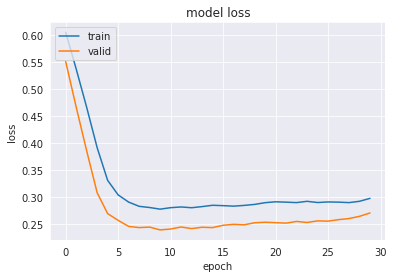

In [23]:
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [24]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [25]:
poly_optimize

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([0.        , 1.        , 2.        , 0.00426978, 0.01160646,
       0.03154963, 0.08576079, 0.233122  , 0.6336913 , 0.00426978,
       0.01160646, 0.03154963, 0.08576079, 0.233122  , 0.6336913 ,
       0.00426978, 0.01160646, 0.03154963, 0.08576079, 0.233122  ,
       0.6336913 ], dtype=float32)>

In [26]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [27]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 91)]         0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          47104       input[0][0]                      
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
hidden2_1024 (Dense)            (None, 1024)         525312      dropout1_0.25[0][0]              
______________________________________________________________________________________________

In [28]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [29]:
scores_test_list[-1].index

Index(['lambda_preds_VS_target_polynomials',
       'lambda_preds_VS_lstsq_lambda_pred_polynomials',
       'lambda_preds_VS_lstsq_target_polynomials',
       'lambda_preds_VS_inet_polynomials',
       'lambda_preds_VS_symbolic_regression_functions',
       'lambda_preds_VS_per_network_polynomials',
       'target_polynomials_VS_lstsq_lambda_pred_polynomials',
       'target_polynomials_VS_lstsq_target_polynomials',
       'target_polynomials_VS_inet_polynomials',
       'target_polynomials_VS_symbolic_regression_functions',
       'target_polynomials_VS_per_network_polynomials',
       'lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials',
       'lstsq_lambda_pred_polynomials_VS_inet_polynomials',
       'lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions',
       'lstsq_lambda_pred_polynomials_VS_per_network_polynomials',
       'lstsq_target_polynomials_VS_inet_polynomials',
       'lstsq_target_polynomials_VS_symbolic_regression_functions',
       'lstsq_target_p

In [30]:
scores_test_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
lambda_preds_VS_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.025,0.033,0.451,-6.405,0.481,1.343,0.032,-0.029,-0.030,0.793,0.797
lambda_preds_VS_lstsq_lambda_pred_polynomials,NaN,NaN,NaN,NaN,NaN,0.004,0.005,0.104,0.999,0.014,0.067,0.005,-0.029,-0.029,0.793,0.793
lambda_preds_VS_lstsq_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.025,0.033,0.489,-5.787,0.470,1.310,0.032,-0.029,-0.030,0.793,0.797
lambda_preds_VS_inet_polynomials,NaN,NaN,NaN,NaN,NaN,0.253,0.278,7.267,-601.876,3.897,3.104,0.156,-0.029,0.122,0.793,0.692
lambda_preds_VS_symbolic_regression_functions,NaN,NaN,NaN,NaN,NaN,inf,inf,inf,-inf,inf,-inf,inf,-0.029,inf,0.793,inf
lambda_preds_VS_per_network_polynomials,NaN,NaN,NaN,NaN,NaN,0.021,0.028,0.590,0.969,0.087,0.279,0.027,-0.029,-0.029,0.793,0.794
target_polynomials_VS_lstsq_lambda_pred_polynomials,3.528,6.186,45.558,0.128,0.000,0.025,0.032,0.139,0.901,0.139,0.371,0.031,-0.030,-0.029,0.797,0.793
target_polynomials_VS_lstsq_target_polynomials,1.486,2.429,16.139,0.210,0.000,0.004,0.004,0.035,0.998,0.021,0.054,0.004,-0.030,-0.030,0.797,0.797
target_polynomials_VS_inet_polynomials,0.534,0.701,3.380,0.063,0.000,0.253,0.279,1.145,-5.625,1.460,1.009,0.154,-0.030,0.122,0.797,0.692
target_polynomials_VS_symbolic_regression_functions,NaN,NaN,NaN,NaN,NaN,inf,inf,inf,-inf,inf,-inf,inf,-0.030,inf,0.797,inf


In [31]:
distrib_dict_test_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,0.010,0.009,0.009,0.005,0.067,0.005,0.016,0.009,0.105,0.011,0.009,0.109,0.013,0.020,0.006,0.007,0.008,0.009,0.017,0.010,0.007,0.011,0.012,0.020,0.006,0.019,0.007,0.012,0.008,0.071,0.078,0.106,0.028,0.011,0.009,0.011,0.114,0.010,0.024,0.020,0.024,0.184,0.005,0.029,0.010,0.068,0.010,0.006,0.012,0.010,0.011,0.080,0.013,0.012,0.011,0.010,0.012,0.014,0.008,0.025,0.008,0.008,0.008,0.013,0.009,0.010,0.010,0.010,0.009,0.049,0.013,0.035,0.131,0.051,0.029,0.007,0.132,0.010,0.013,0.010,0.011,0.013,0.015,0.007,0.015,0.033,0.010,0.089,0.011,0.013,0.009,0.039,0.005,0.014,0.011,0.033,0.016,0.008,0.012,0.014
lambda_preds_VS_lstsq_lambda_pred_polynomials,0.006,0.005,0.007,0.002,0.000,0.002,0.009,0.004,0.000,0.005,0.006,0.000,0.007,0.005,0.002,0.006,0.005,0.003,0.006,0.006,0.002,0.002,0.002,0.010,0.003,0.009,0.002,0.001,0.002,0.001,0.000,0.000,0.002,0.001,0.000,0.007,0.000,0.004,0.006,0.008,0.012,0.000,0.004,0.000,0.006,0.000,0.003,0.003,0.002,0.007,0.007,0.001,0.007,0.004,0.003,0.005,0.001,0.001,0.006,0.018,0.006,0.002,0.005,0.003,0.004,0.002,0.007,0.002,0.005,0.000,0.007,0.000,0.000,0.000,0.000,0.002,0.000,0.004,0.005,0.002,0.004,0.001,0.011,0.001,0.007,0.000,0.008,0.000,0.002,0.003,0.005,0.000,0.002,0.001,0.007,0.000,0.005,0.005,0.002,0.005
lambda_preds_VS_lstsq_target_polynomials,0.010,0.010,0.010,0.007,0.066,0.006,0.018,0.009,0.104,0.013,0.006,0.109,0.013,0.019,0.006,0.009,0.009,0.008,0.018,0.011,0.005,0.011,0.014,0.022,0.007,0.021,0.006,0.011,0.008,0.072,0.076,0.105,0.029,0.010,0.010,0.012,0.112,0.008,0.025,0.021,0.025,0.185,0.005,0.027,0.010,0.066,0.007,0.008,0.015,0.009,0.011,0.077,0.012,0.010,0.011,0.009,0.010,0.016,0.008,0.025,0.007,0.008,0.010,0.015,0.009,0.010,0.010,0.008,0.010,0.049,0.013,0.034,0.131,0.055,0.029,0.009,0.131,0.010,0.012,0.009,0.009,0.012,0.015,0.008,0.014,0.035,0.012,0.089,0.012,0.012,0.007,0.037,0.006,0.011,0.011,0.032,0.013,0.008,0.010,0.017
lambda_preds_VS_inet_polynomials,0.556,0.152,0.128,0.195,0.132,0.057,0.083,0.283,0.332,0.139,0.035,0.142,0.425,0.290,0.068,0.103,0.187,0.557,0.135,0.027,0.088,0.117,0.784,0.159,0.293,0.374,0.355,0.125,0.189,0.081,0.104,0.544,0.061,0.072,0.487,0.067,0.534,0.174,0.118,0.262,0.265,0.105,0.119,0.112,0.169,0.640,0.097,0.216,0.122,0.151,0.097,0.140,0.492,0.065,0.113,0.440,0.962,0.089,0.311,0.205,0.122,0.033,0.126,0.111,0.049,0.034,0.055,0.581,0.061,0.058,0.104,0.959,0.372,0.068,0.891,0.528,0.326,0.159,0.075,0.159,0.129,0.158,0.326,0.186,0.474,0.726,0.138,0.678,0.102,0.759,0.190,0.298,0.163,0.099,0.334,0.434,0.219,0.046,0.766,0.277
lambda_preds_VS_symbolic_regression_functions,0.189,0.076,0.079,0.031,0.006,0.014,0.057,0.031,0.064,0.045,0.035,0.006,0.022,0.036,0.010,0.042,0.103,0.062,0.119,0.087,0.006,0.010,0.102,0.040,0.026,0.060,0.041,0.010,0.034,0.008,0.005,0.006,0.010,0.010,0.025,0.053,0.043,0.035,0.051,0.052,0.036,0.032,0.060,0.079,0.115,inf,0.080,0.149,0.015,0.097,0.030,0.002,0.126,0.042,0.069,0.027,0.010,0.025,0.029,0.035,0.053,0.049,0.054,0.007,0.031,0.036,0.030,0.062,0.066,0.006,0.083,0.028,0.008,0.039,0.059,0.033,0.004,0.019,0.048,0.058,0.040,0.054,0.129,0.041,0.077,0.008,0.037,0.004,0.010,0.098,0.078,0.006,0.045,0.028,0.020,0.004,0.036,0.040,0.130,0.022
lambda_preds_VS_per_network_polynomials,0.012,0.029,0.026,0.091,0.000,0.007,0.032,0.005,0.000,0.013,0.013,0.000,0.016,0.046,0.010,0.008,0.017,0.009,0.037,0.016,0.015,0.005,0.015,0.033,0.021,0.047,0.010,0.006,0.007,0.000,0.000,0.000,0.011,0.002,0.058,0.010,0.049,0.011,0.032,0.030,0.028,0.016,0.009,0.000,0.013,

In [32]:
distrib_dict_test_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,0.998,0.998,1.000,1.000,0.448,1.000,0.990,0.996,-2.212,0.987,0.999,-0.242,1.000,0.997,0.984,0.997,0.986,0.979,0.997,0.999,0.997,0.998,0.985,0.999,1.000,0.998,0.963,0.327,0.999,-13.155,-282.058,-1.047,0.945,0.992,0.998,0.991,0.612,0.996,0.998,0.998,0.998,-0.464,0.990,0.852,1.000,0.867,0.985,0.998,0.996,0.995,0.999,0.615,0.988,0.994,0.999,0.999,0.997,0.982,1.000,0.999,1.000,0.999,0.988,0.996,0.999,0.997,0.999,0.966,1.000,0.851,0.999,0.967,0.604,-1.055,0.975,0.997,-0.173,1.000,0.999,0.962,0.999,0.987,0.998,0.963,0.994,0.797,0.999,0.457,0.997,0.987,1.000,0.956,0.967,0.994,0.996,-426.845,0.999,0.995,0.995,0.998
lambda_preds_VS_lstsq_lambda_pred_polynomials,0.999,0.999,1.000,1.000,1.000,1.000,0.997,1.000,1.000,0.998,1.000,1.000,1.000,1.000,0.999,0.999,0.997,0.998,1.000,1.000,1.000,1.000,0.999,1.000,1.000,1.000,0.997,0.992,1.000,0.998,0.999,1.000,1.000,1.000,1.000,0.997,1.000,0.999,1.000,1.000,0.999,1.000,0.996,1.000,1.000,1.000,0.999,0.999,1.000,0.998,1.000,1.000,0.997,0.999,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000,0.998,1.000,1.000,1.000,1.000,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.998,1.000,1.000,0.999,0.999,0.998,1.000,1.000,1.000,1.000,0.999,1.000,1.000,0.997,1.000,0.999,0.997,1.000,0.999,1.000,1.000
lambda_preds_VS_lstsq_target_polynomials,0.998,0.998,1.000,1.000,0.475,0.999,0.988,0.996,-2.147,0.982,1.000,-0.259,1.000,0.997,0.979,0.997,0.983,0.985,0.996,0.999,0.998,0.998,0.984,0.998,0.999,0.998,0.968,0.261,0.999,-13.611,-274.837,-1.013,0.940,0.995,0.998,0.988,0.615,0.997,0.997,0.998,0.998,-0.443,0.991,0.878,1.000,0.874,0.988,0.997,0.994,0.995,0.999,0.636,0.988,0.996,0.998,0.999,0.997,0.978,1.000,0.999,1.000,0.999,0.987,0.996,0.999,0.997,0.999,0.972,0.999,0.852,0.999,0.969,0.600,-1.383,0.975,0.996,-0.150,1.000,0.999,0.971,0.999,0.989,0.998,0.963,0.994,0.771,0.999,0.470,0.997,0.989,1.000,0.961,0.954,0.996,0.996,-371.578,0.999,0.996,0.996,0.997
lambda_preds_VS_inet_polynomials,-3.071,0.744,0.956,0.706,-0.435,0.964,0.679,-1.171,-24.318,-0.034,0.993,-0.447,0.642,0.463,-0.665,0.732,-1.593,-52.833,0.846,0.996,0.403,0.800,-33.811,0.934,0.520,0.420,-55.064,-53.350,0.745,-14.084,-349.085,-37.437,0.755,0.612,-3.079,0.799,-4.592,0.380,0.938,0.738,0.741,0.590,-1.229,-0.608,0.950,-7.244,-0.295,-0.484,0.691,0.168,0.934,0.310,-10.200,0.847,0.850,0.145,-13.108,0.384,0.522,0.926,0.950,0.988,-0.097,0.785,0.977,0.977,0.985,-58.396,0.983,0.749,0.935,-17.981,-1.437,-1.937,-18.066,-10.703,-4.661,0.912,0.987,-4.826,0.925,-0.912,0.356,-11.580,-4.242,-69.343,0.931,-19.106,0.815,-33.293,0.896,-1.104,-8.772,0.775,-0.355,-59278.097,0.829,0.923,-16.337,0.393
lambda_preds_VS_symbolic_regression_functions,-0.074,0.917,0.978,0.992,0.997,0.998,0.691,0.952,-0.003,0.803,0.993,0.996,0.998,0.991,0.959,0.915,-0.046,-0.063,0.807,0.882,0.997,0.997,-0.096,0.995,0.993,0.987,-0.051,-0.057,0.987,0.866,-0.010,0.995,0.993,0.992,0.988,0.796,0.957,0.957,0.989,0.984,0.992,0.965,-0.160,-0.001,0.965,-inf,-0.122,-0.000,0.990,0.087,0.995,1.000,-0.032,0.938,0.900,0.997,0.998,0.931,0.997,0.997,0.986,0.957,0.520,0.998,0.992,0.975,0.996,-0.072,0.960,0.998,0.967,0.980,0.999,-0.000,0.891,0.944,0.999,0.999,0.995,-0.005,0.993,0.669,0.892,-0.200,0.837,0.990,0.991,0.999,0.997,-0.160,0.972,0.999,-0.069,0.976,0.995,-3.690,0.995,0.881,-0.273,0.995
lambda_preds_VS_per_network_polynomials,0.995,0.989,0.998,0.924,1.000,0.999,0.972,0.999,1.000,0.988,0.999,1.000,0.999,0.975,0.959,0.999,0.970,0.980,0.984,0.998,0.981,0.999,0.984,0.997,0.995,0.

In [33]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_min]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-134.14922244729578


-0.647856116294861*a**3.0 - 0.152500912547112*a**4.0 - 0.209853231906891*a**5.0

In [34]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['lstsq_lambda_pred_polynomials_VS_inet_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-53.65461881745678


0.809960047477607*a**1.0 - 3.07354570366101*a**2.0 + 5.54189600557843*a**3.0 - 4.70677779224651*a**4.0 + 1.52265378373864*a**5.0 + 0.516068520829567

In [35]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.872432996439497*a**1.0 - 0.837077223208218*a**2.0 - 0.842908166053767*a**3.0 + 0.67129187551574*a**4.0 + 0.282531506445772*a**5.0 - 0.734067903951813

In [36]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_max]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.9012942396833331


-0.479830980300903*a**1.0 - 0.46510523557663*a**4.0 - 1.22373712062836*a**5.0

In [37]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9997075962452567


-0.441200927710424*a**1.0 - 3.74337670881276*a**2.0 + 6.71408937231949*a**3.0 - 8.65114962107941*a**4.0 + 3.96181145886717*a**5.0 + 0.276937011506757

In [38]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.816747031001418*a**1.0 - 0.95809565941095*a**2.0 - 0.898432721526497*a**3.0 + 0.218791526864481*a**4.0 + 0.22803082978917*a**5.0 + 0.287988945708397

In [39]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -5.624872266029289 (100 Samples)
Mean (only positive): 0.7092036300082215 (59 Samples)


In [40]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9008735853157992 (100 Samples)
Mean (only positive): 0.9296350024142401 (97 Samples)


<AxesSubplot:xlabel='target_polynomials_VS_inet_polynomials', ylabel='Count'>

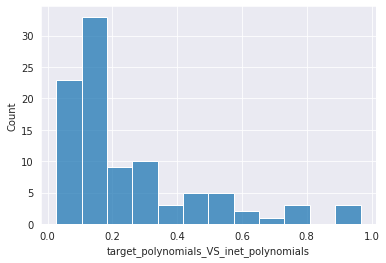

In [41]:
sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50])


<AxesSubplot:xlabel='target_polynomials_VS_lstsq_lambda_pred_polynomials', ylabel='Count'>

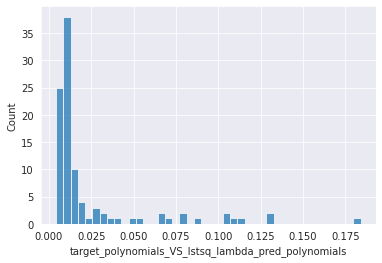

In [42]:
sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50])


[(-30.0, 1.0)]

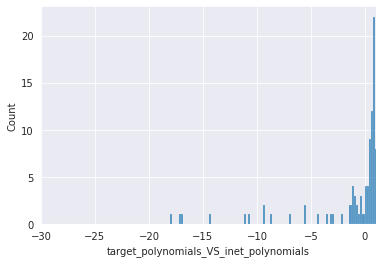

In [43]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

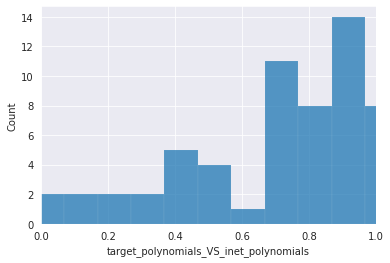

In [44]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

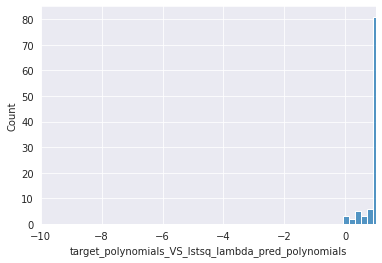

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

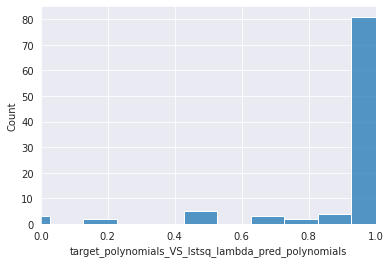

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

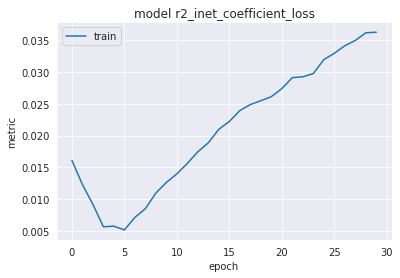

In [47]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


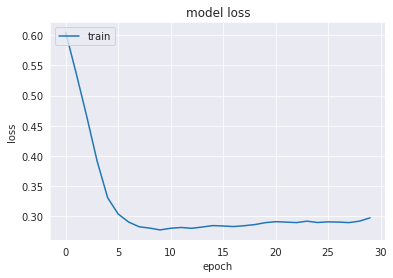

In [48]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [49]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [50]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [51]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [52]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


-0.1089*a**1.0 + 4.2759*a**2.0 - 11.677*a**3.0 + 12.2308*a**4.0 - 3.8129*a**5.0 - 0.3189

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.9886*a**1.0 - 1.4002*a**2.0 + 1.4736*a**3.0 - 2.2087*a**4.0 + 2.213*a**5.0 - 0.3826

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.8804*a**1.0 - 0.7895*a**2.0 - 0.3549*a**3.0 + 0.3058*a**4.0 + 0.9988*a**5.0 - 0.3765

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


-0.422500014305115*a**1.0 + 0.552500009536743*a**3.0 + 0.424499988555908*a**4.0

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


0.45*x - 0.3375

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
per_network_polynomials


0.792200028896332*a**3.0 - 0.251999996602535

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


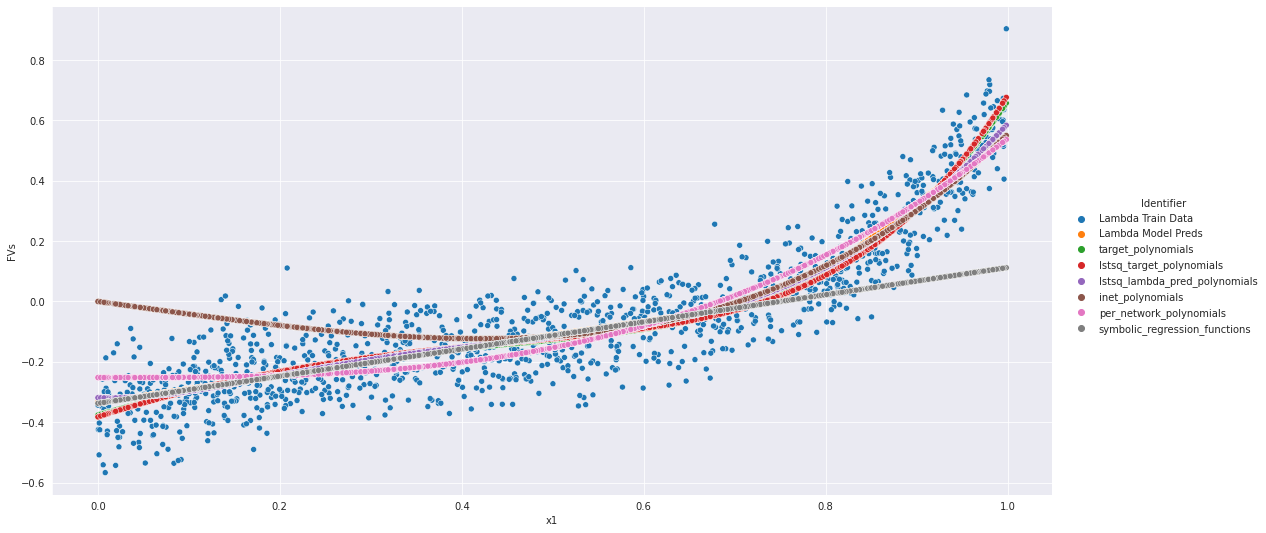

In [53]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

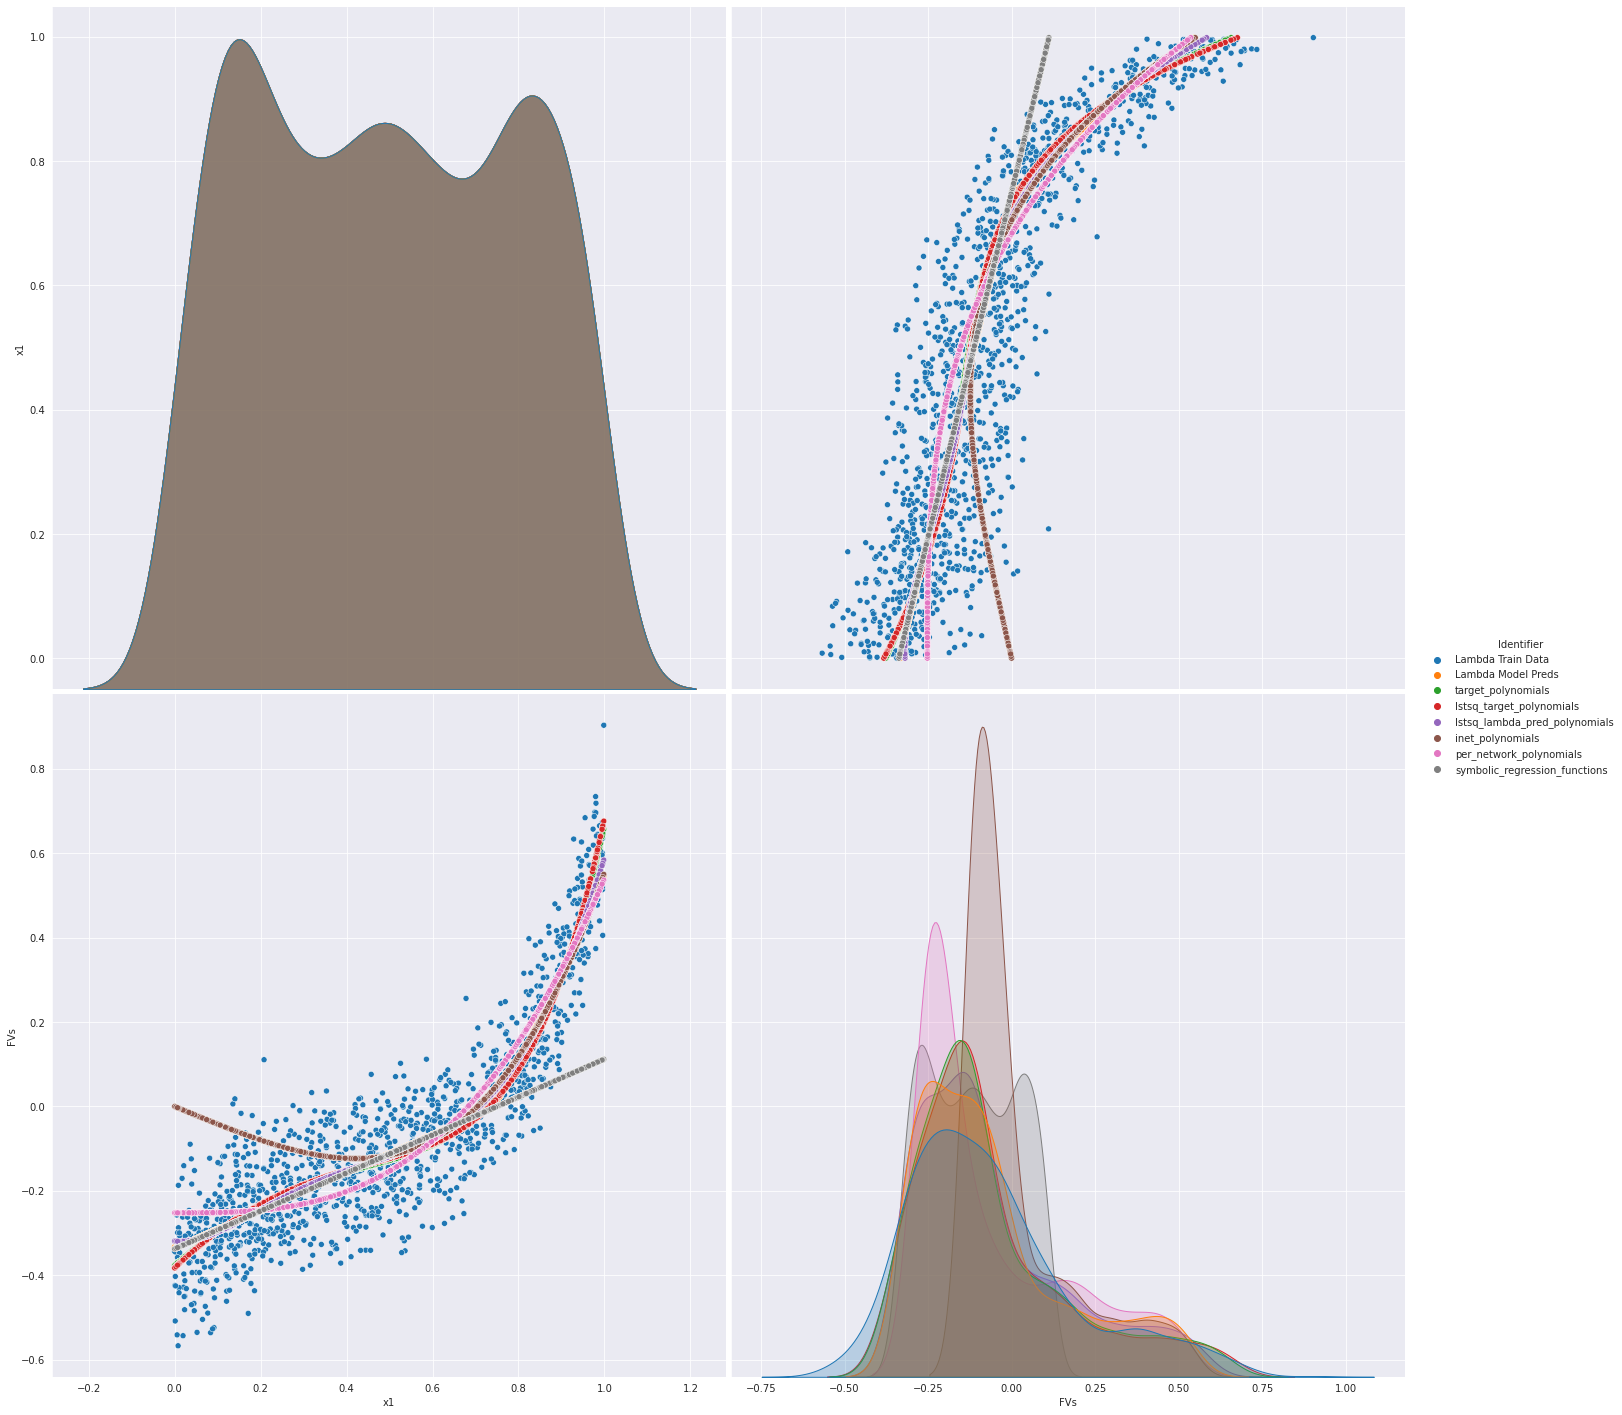

In [54]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

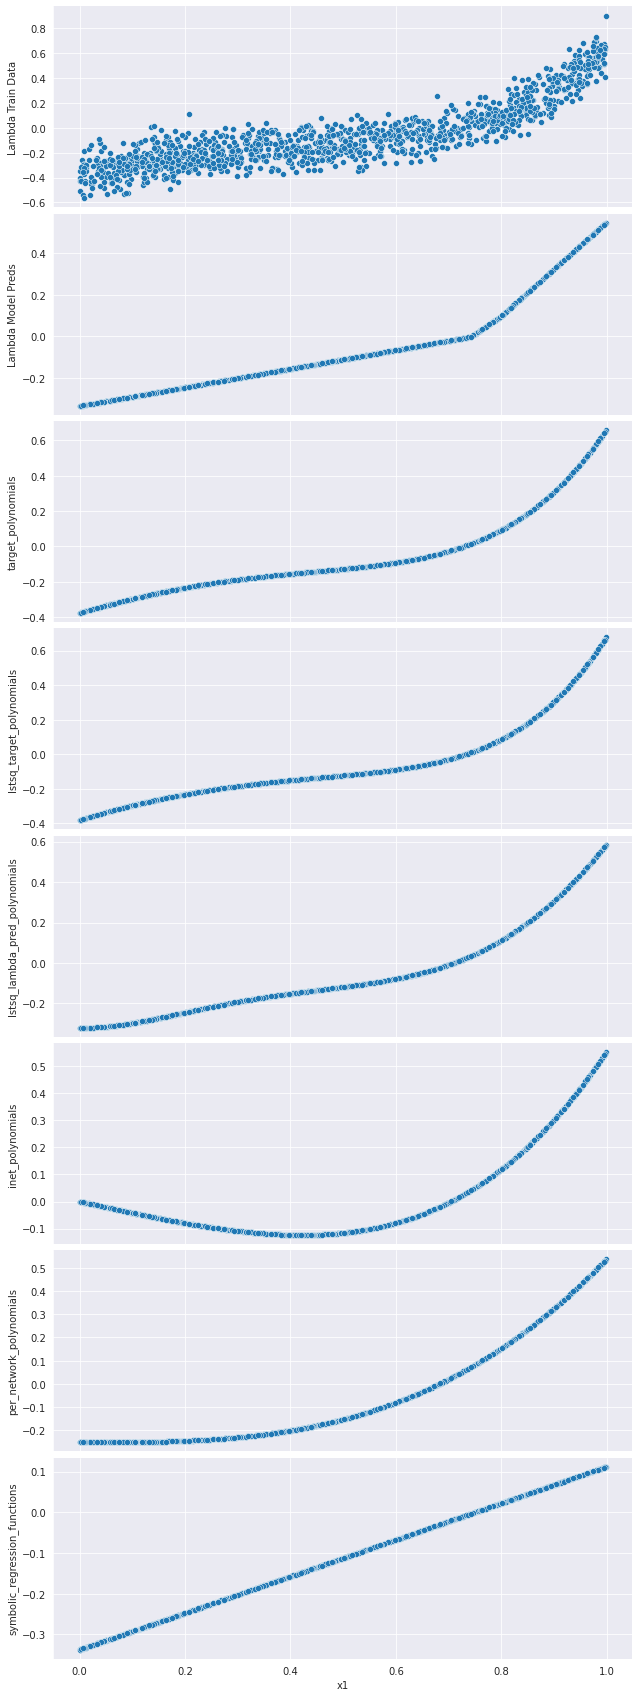

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [56]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [57]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [58]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0187


In [59]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.7229


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [60]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [61]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.6381


In [62]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [63]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


Current best: 0.16708682477474213 
 Curr_res: 0.20078645646572113 
 Iteration 1, Step 17
Optimization terminated at 0.14762061834335327


array([ 0.68916106, -0.7294802 ,  0.25654602,  0.9118674 ,  0.637642  ,
        0.18209696,  0.63791955,  0.27701473,  0.04227114,  0.84219384,
        0.90637195,  0.222556  ,  0.9198462 ,  0.68789077,  0.42705178,
        0.878158  ,  0.6943959 ,  0.46567595,  0.52925766,  0.33019018,
        0.12754858], dtype=float32)

# Evaluate Real Dataset


##  Auto MPG-Dataset

In [64]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == train_features_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

,Horsepower
0,0.457
1,0.647
2,0.565
3,0.565
4,0.511


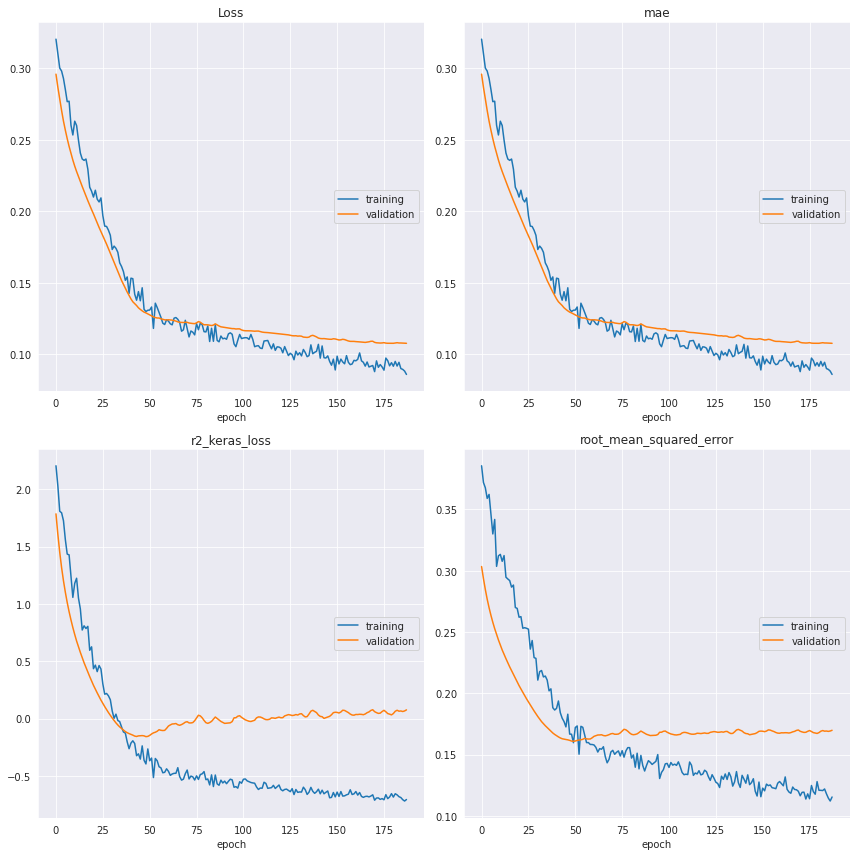

Loss
	training         	 (min:    0.086, max:    0.320, cur:    0.086)
	validation       	 (min:    0.108, max:    0.296, cur:    0.108)
mae
	training         	 (min:    0.086, max:    0.320, cur:    0.086)
	validation       	 (min:    0.108, max:    0.296, cur:    0.108)
r2_keras_loss
	training         	 (min:   -0.719, max:    2.204, cur:   -0.706)
	validation       	 (min:   -0.157, max:    1.785, cur:    0.076)
root_mean_squared_error
	training         	 (min:    0.112, max:    0.386, cur:    0.115)
	validation       	 (min:    0.161, max:    0.303, cur:    0.170)


In [97]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[42], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

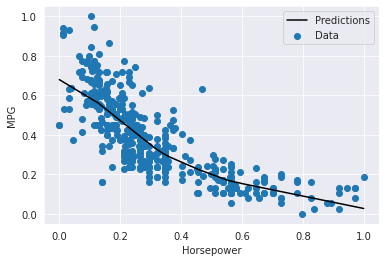

In [98]:
if interpretation_possible_autoMPG:
    x = tf.linspace(0.0, 1, 250)#tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [99]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [100]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQt Poly:


0.28163691138332*a**1.0 + 0.613213238961091*a**2.0 + 0.553529554765608*a**3.0 + 0.447782773385697*a**4.0 + 0.520913517873087*a**5.0 + 0.559899658248737

MAE Model:  0.002897869875749576
MAE Data:  0.08316318517812354
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [101]:
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


-0.0482636764645576*a**1.0 + 0.289542704820633*a**3.0 + 0.346974581480026*a**4.0

MAE Model:  0.38426519252003094
MAE Data:  0.36632162722815514
Computation Time: 0:00:00
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [102]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


Current best: 0.19848878681659698 
 Curr_res: 0.1988232582807541 
 Iteration 2, Step 259
Optimization terminated at 0.09904497116804123
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


0.313677411526442 - 0.369614988565445*a**3.0

MAE Model:  0.12336576304717801
MAE Data:  0.13609714197460704
Computation Time: 0:00:14
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [103]:
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          15445.2       15        0.0491301        0.0478253      3.93m
   1    10.85          8.88239       13        0.0478341        0.0426176      2.22m
   2     6.68          1.21869       15        0.0306637        0.0295294      1.83m
   3     5.26         0.887935       11        0.0350414        0.0372723      1.66m
   4     4.42         0.601584        5        0.0457394        0.0534622      1.67m
   5     5.36         0.646721        5        0.0447633        0.0622469      1.71m
   6     5.25          6.93469        5        0.0450482        0.0596826      1.42m
   7     5.30         0.831231        5          0.04523        0.0580468      1.26m
   8     5.27           7.0703        5        0.0449364        0.0606894  

0.555273 - 0.599*x

MAE Model:  0.04585478321533237
MAE Data:  0.09551056046933114
Computation Time: 0:02:27
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [104]:
#%autoreload 2
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [105]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [106]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function:')
    #display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


-0.0482636764645576*a**1.0 + 0.289542704820633*a**3.0 + 0.346974581480026*a**4.0

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


0.313677411526442 - 0.369614988565445*a**3.0

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQ Poly:


-0.423710596336098*a**1.0 - 5.16991004481561*a**2.0 + 13.8768564148898*a**3.0 - 13.5756772315681*a**4.0 + 4.65379922847526*a**5.0 + 0.669712443698242

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Symbolic Regression Function:


0.555273 - 0.599*x

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


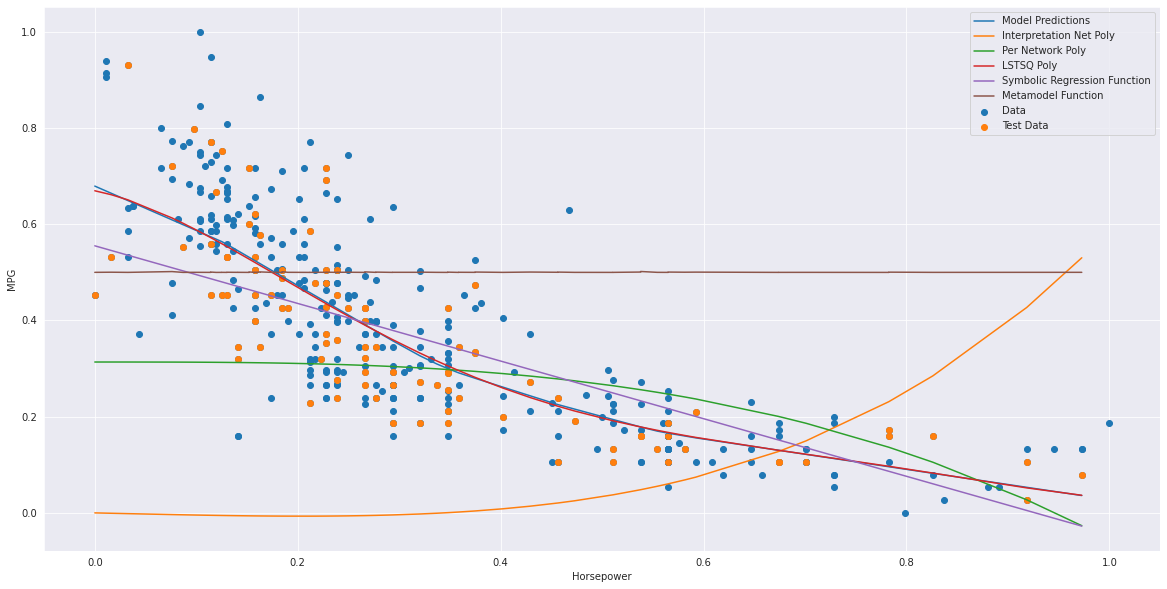

In [107]:
if interpretation_possible_autoMPG:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [93]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


0.11503005027771*a**1.0 + 0.287310183048248*a**3.0 + 0.0939906015992165*a**5.0

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


0.375537674874067 - 0.577467262744904*a**3.0

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQ Poly:


0.23986891669695*a**1.0 - 4.12624158945478*a**2.0 + 7.68655922420647*a**3.0 - 6.41596747470711*a**4.0 + 2.01402942942627*a**5.0 + 0.520853155922688

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Symbolic Regression Function:


0.562 - 0.648*x

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Metamodel Function:


1/(1.0000239380709*exp(0.000459548616380347*X0**5 - 0.00172816057492219*X0**4 + 0.00357899796782724*X0**3 - 0.00977334695710157*X0**2 - 0.00052505637533622*X0) + 1)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


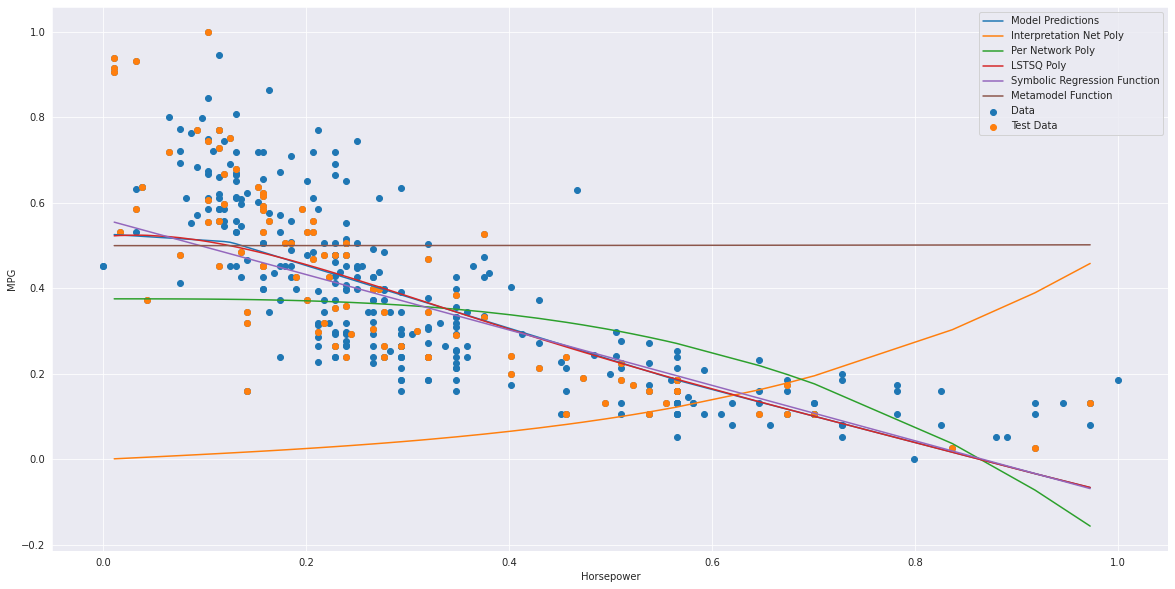

In [94]:
if interpretation_possible_autoMPG:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])


In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y*100,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=50,
         verbose=0)

In [ ]:
model_2 = keras.models.clone_model(model)

model_2.summary()

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights#[weights/10 for weights in model_2_weights]

In [ ]:
model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/10


In [ ]:
model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/100


In [ ]:
model_2.set_weights(model_2_normalized_weights)

In [ ]:
model_2.get_weights()

In [ ]:
model_2.predict([1, 10])

In [ ]:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    if length_plt >= 2:
        fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(20,10))

    for index, metric in enumerate(plot_metric_list):
        
        plot_scores_dict = {}
        for key in evaluation_key_list:
            try:
                scores_list[-1][metric].loc[key]
                plot_scores_dict[key] = []
            except:
                #print(key + 'not in scores_list')
                continue
            
        
        for scores in scores_list:
            for key in evaluation_key_list:
                try:
                    plot_scores_dict[key].append(scores[metric].loc[key])
                except:
                    #print(key + 'not in scores_list')
                    continue
                                        
            
        plot_df = pd.DataFrame(data=np.vstack(plot_scores_dict.values()).T, 
                               index=x_axis_steps,
                               columns=plot_scores_dict.keys())

        if length_plt >= 2:
            ax[index//2, index%2].set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        else:
            ax.set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax)

        if ylim != None:
            p.set(ylim=ylim)

        p.set_yticklabels(np.round(p.get_yticks(), 2), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)     
        
        #p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        p.legend(loc='upper center', bbox_to_anchor=(0.47, -0.1),
          fancybox=False, shadow=False, ncol=2, fontsize=12)   
        
    plt.subplots_adjust(wspace=0.1, hspace=0.75)

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()